## Modelo de predicción de edad

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("frabbisw/facial-age")

RAW_DIR = os.path.join(path, "face_age")
if not os.path.isdir(RAW_DIR):
    RAW_DIR = path

random.seed(42)
OUT_DIR = "data"
LABELS = {'<18': range(1,18), '18+': range(18,200)}
MAX_PER_CLASS = 10000

# Recolectar imágenes
all_imgs = []
for sub in os.listdir(RAW_DIR):
    age_str = sub.rstrip('+')
    try:
        age = int(age_str)
    except ValueError:
        continue
    label = '<18' if age < 18 else '18+'
    folder = os.path.join(RAW_DIR, sub)
    for fn in os.listdir(folder):
        all_imgs.append((os.path.join(folder, fn), label))

# Balancear clases
by_label = {'<18': [], '18+': []}
for path_img,lab in all_imgs:
    by_label[lab].append(path_img)

sampled = []
for lab, paths in by_label.items():
    n = min(len(paths), MAX_PER_CLASS)
    sampled += [(p, lab) for p in random.sample(paths, n)]

# Split estratificado
labels = [lab for _,lab in sampled]
train, temp = train_test_split(sampled, test_size=0.30, stratify=labels, random_state=42)
labels_temp = [lab for _,lab in temp]
val, test  = train_test_split(temp, test_size=0.50, stratify=labels_temp, random_state=42)

# Crear carpetas y copiar imágenes
for split, dataset in (('train',train), ('val',val), ('test',test)):
    for label in ['<18','18+']:
        os.makedirs(os.path.join(OUT_DIR, split, label), exist_ok=True)
    for src, lab in dataset:
        dst = os.path.join(OUT_DIR, split, lab, os.path.basename(src))
        if not os.path.exists(dst):
            shutil.copy(src, dst)


print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/facial-age


In [ ]:
"""import os
import shutil

source_dir = '/kaggle/input/facial-age/face_age'
target_dir = '/kaggle/working/face_age_cleaned'

os.makedirs(target_dir, exist_ok=True)

for item in os.listdir(source_dir):
    src_path = os.path.join(source_dir, item)
    dst_path = os.path.join(target_dir, item)

    # Omitimos la carpeta duplicada
    if item == 'face_age':
        continue

    if os.path.isdir(src_path):
        shutil.copytree(src_path, dst_path)
    else:
        shutil.copy2(src_path, dst_path)

print("Contenido copiado a /kaggle/working/face_age_cleaned sin la carpeta problemática.")"""

Contenido copiado a /kaggle/working/face_age_cleaned sin la carpeta problemática.


In [ ]:
# normalizar_imagenes.py
import os
import shutil

source_dir = '/kaggle/working/face_age_cleaned'
target_dir = '/kaggle/working/face_age_cleaned_binary'

# Crear carpetas destino
os.makedirs(os.path.join(target_dir, '0'), exist_ok=True)  # Menores de edad
os.makedirs(os.path.join(target_dir, '1'), exist_ok=True)  # Mayores de edad

for folder_name in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder_name)

    if not os.path.isdir(folder_path):
        continue

    try:
        edad = int(folder_name)  # Ej: '024' → 24
    except ValueError:
        continue

    clase = '0' if edad < 18 else '1'
    destino_clase = os.path.join(target_dir, clase)

    for filename in os.listdir(folder_path):
        src_path = os.path.join(folder_path, filename)

        if os.path.isfile(src_path):
            dst_path = os.path.join(destino_clase, f"{folder_name}_{filename}")
            shutil.copy2(src_path, dst_path)

print("✔️ Imágenes clasificadas por edad en face_age_cleaned_binary/")

✔️ Imágenes clasificadas por edad en face_age_cleaned_binary/


In [ ]:
# 1. Librerías
import kagglehub
import os
import shutil
import random
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 6. Modelo CNN
input_shape = (224, 224, 3)
batch_size = 32
epochs = 20
DATA_DIR = "/kaggle/working/face_age_cleaned_binary"


# Generador de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle= True
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

def crear_modelo_cnn(input_shape):
    model = models.Sequential()

    # Bloque 1
    model.add(layers.Conv2D(32, (3, 3), activation='leaky_relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloque 2
    model.add(layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloque 3
    model.add(layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloque 4 (opcional)
    model.add(layers.Conv2D(256, (3, 3), activation='leaky_relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Clasificación
    model.add(layers.Flatten())
    model.add(layers.Dense(156, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # salida binaria

    return model

"""
input_layer = layers.Input(shape=input_shape)

layer_conv = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_layer)
batch_normalization = layers.BatchNormalization()(layer_conv)
pool = layers.MaxPooling2D((2, 2))(batch_normalization)

layer_conv = layers.Conv2D(64, (3,3), padding='same', activation='relu')(pool)
batch_normalization = layers.BatchNormalization()(layer_conv)
pool = layers.MaxPooling2D((2, 2))(batch_normalization)

layer_conv = layers.Conv2D(128, (3,3), padding='same', activation='relu')(pool)
batch_normalization = layers.BatchNormalization()(layer_conv)
pool = layers.MaxPooling2D((2, 2))(batch_normalization)

flatten = layers.Flatten()(pool)
dense = layers.Dense(250, activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense)
output = layers.Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=input_layer, outputs=output)
"""

model = crear_modelo_cnn(input_shape)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name="AUC"),
                       tf.keras.metrics.Precision(name="precision"),
                       tf.keras.metrics.Recall(name="recall")])

model.summary()

# 8. Entrenar

checkpoint = ModelCheckpoint(
    filepath='mejor_modelo5.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

#early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    callbacks=[checkpoint])




Found 7823 images belonging to 2 classes.
Found 1955 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 156)            │     7,827,612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 156)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           157 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,218,105 (31.35 MB)

 Trainable params: 8,217,145 (31.35 MB)

 Non-trainable params: 960 (3.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - AUC: 0.7801 - accuracy: 0.7478 - loss: 1.8071 - precision: 0.7834 - recall: 0.8085
Epoch 1: val_loss improved from inf to 8.87121, saving model to mejor_modelo5.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - AUC: 0.7803 - accuracy: 0.7480 - loss: 1.8033 - precision: 0.7835 - recall: 0.8087 - val_AUC: 0.5028 - val_accuracy: 0.5985 - val_loss: 8.8712 - val_precision: 0.5985 - val_recall: 1.0000
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9286 - accuracy: 0.8645 - loss: 0.3289 - precision: 0.8647 - recall: 0.9182
Epoch 2: val_loss improved from 8.87121 to 0.78038, saving model to mejor_modelo5.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - AUC: 0.9286 - accuracy: 0.8645 - loss: 0.3288 - precision: 0.8647 - recall: 0.9182 - val_AUC: 0.9640 - val_accuracy: 0.7156 - val_loss: 0.7804 - val_precision: 0.9782 - val_recall: 0.5368
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9541 - accuracy: 0.89

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import pandas as pd

# Configuración
BATCH_SIZE = 32
DATA_DIR = "/kaggle/working/face_age_cleaned_binary"

# Generador de datos sin mezcla, para evaluación
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False  # Importante para que coincidan los índices con las predicciones
)

# Cargar modelo entrenado
model = tf.keras.models.load_model("/content/mejor_modelo5.keras")

# Predicciones
predictions = model.predict(val_gen)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Clasificación detallada
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Graficar
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axs[0])
axs[0].set_title("Matriz de Confusión")
axs[0].set_xlabel("Predicción")
axs[0].set_ylabel("Real")

# Gráfico de métricas por clase
df_report.loc[['0', '1'], ['precision', 'recall', 'f1-score']].plot(kind='bar', ax=axs[1])
axs[1].set_title("Precisión, Recall y F1-score por clase")
axs[1].set_xticklabels(['Menor de edad (0)', 'Mayor de edad (1)'], rotation=0)
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/face_age_cleaned_binary'

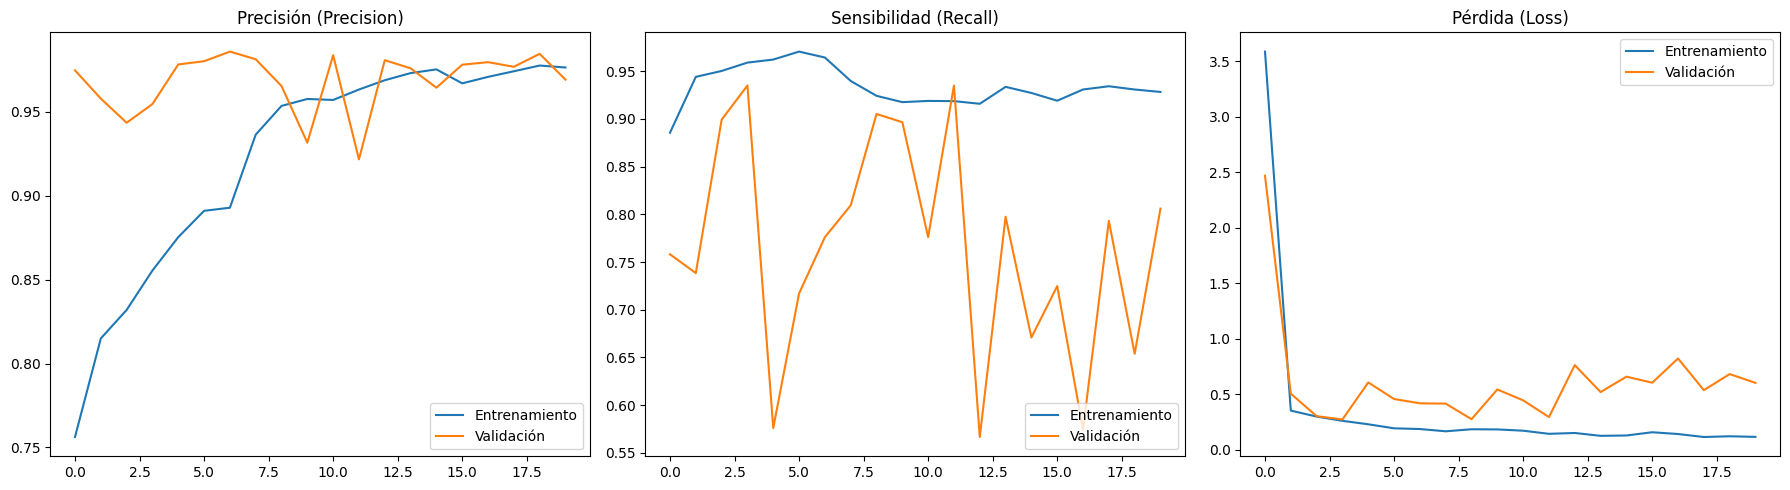

In [ ]:
import matplotlib.pyplot as plt

# Extraer métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs_range = range(epochs)

# Crear gráficas
plt.figure(figsize=(18, 5))

# Precisión (Precision)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, precision, label='Entrenamiento')
plt.plot(epochs_range, val_precision, label='Validación')
plt.legend(loc='lower right')
plt.title('Precisión (Precision)')

# Sensibilidad (Recall)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, recall, label='Entrenamiento')
plt.plot(epochs_range, val_recall, label='Validación')
plt.legend(loc='lower right')
plt.title('Sensibilidad (Recall)')

# Pérdida (Loss)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.legend(loc='upper right')
plt.title('Pérdida (Loss)')

plt.tight_layout()
plt.show()


In [ ]:
model.save("modelo_edad.keras")

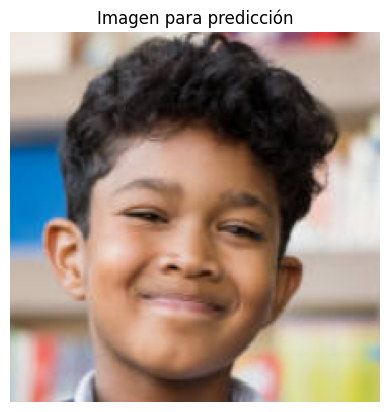

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Reemplaza por el nombre real de tu imagen subida
img_path = "/content/Captura de pantalla 2025-05-28 212743.png"

# Mostrar la imagen
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.title("Imagen para predicción")
plt.show()

# Preprocesar imagen
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Añadir batch dimension
img_array = img_array / 255.0  # Normalizar (opcional, si entrenaste así)

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model("/content/mejor_modelo2.keras")

# Ahora puedes hacer predicciones
prediction = model.predict(img_array)

# Mostrar resultado
if prediction[0] >= 0.5:
    print("🧓 Predicción: MAYOR de edad")
else:
    print("🧒 Predicción: MENOR de edad")

print(f"Probabilidad: {float(prediction[0]):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
🧒 Predicción: MENOR de edad
Probabilidad: 0.1859


<ipython-input-59-2b5a15553022>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Probabilidad: {float(prediction[0]):.4f}")
